# Word2vec 

## 神经概率语言模型

![](https://github.com/applenob/deep_learning_note/raw/master/res/neu_lan_model.png)

- 词向量：$v(w) \in R^m$
- $m$是词向量的维度，通常是$10^1\sim 10^2$的量级。
- 神经网络参数：$W \in R^{n_h×(n-1)m}$，$p \in R^{n_h}$，$U\in R^{n_h×N}$，$q \in R^N$
- $n$：上下文词数，通常不超过5。
- $n_h$：隐层的维度，用户指定，通常是$10^2$的量级。
- $N$：语料的大小，通常是$10^4\sim 10^5$的量级。
- 通过神经网络的反向传播，更新$v(w)$，最终获得w2v。
- $x_w$是各词向量之和。

## CBOW
![](https://github.com/applenob/deep_learning_note/raw/master/res/cbow.png)

## Skip-Gram
![](https://github.com/applenob/deep_learning_note/raw/master/res/skip_gram.png)

## 如何解决类别过多的问题？

Corpus的数量是$N$，那么分类的类别即$N$。直接拿去做这么多个类的分类：输出层的参数$U\in R^{n_h×N}$，太大。解决的思路有两个：
- 1.将一次的多分类转换为多次的二分类：**Hierachical Softmax**。这样，针对每一个分类器有一个参数向量，参数量是：$log_2N×m$。
- 2.每个词向量对应一个参数向量，参数量稍有下降，是：$N×m$，但每次训练只更新其中的一部分，而不是全部：**负采样**。

## Hierachical Softmax的梯度计算（CBOW）

- $p^w$：从根结点出发到达$w$对应叶子结点的**路径**。
- $l^w$：路径$p^w$中包含结点的**个数**。
- $p_1^w,p_2^w,...,p_{l^w}^w$：路径$p^w$中的$l^w$个结点，其中，$p^w_1$表示根结点，$p_{l^w}^w$表示词$w$对应的**结点**。
- $d_2^w,...,d_{l^w}^w \in \{0,1\}$：词$w$的Huffman编码，由$l^w-1$位编码组成（根结点不编码），$d_j^w$表示路径$p^w$中第$j$个结点对应的**编码**。
- $\theta_1^w,\theta_2^w,...,\theta_{l^w-1}^w \in R^m$：路径$p^w$中**非叶子结点**对应的向量，$\theta_j^w$表示路径中$p^w$中第$j$个非叶子结点对应的**向量**。

对于词典$D$中的任意词$w$，Huffman树中必存在一条从根节点到词$w$对应结点的唯一的路径$p^w$。路径$p^w$上存在$l^w-1$个分支，每个分支即一次二次分类，每次分类产生一个概率，将所有这些概率乘起来，就是所需的$p(w|Context(w))$。

$p(w|Context(w)) = \prod_{j=2}^{l^w}p(d_j^w|x_w,\theta^w_{j-1})$

其中：$p(d_j^w|x_w,\theta^w_{j-1})=\left\{\begin{matrix}
\sigma(x_w^T\theta^w_{j-1}),\;\;d_j^w=0\\ 
1-\sigma(x_w^T\theta^w_{j-1}),\;\;d_j^w=1\end{matrix}\right.$

## 基于负采样的模型（CBOW）

- **目的**：提高训练速度，改善所得词向量的质量。
- 不使用Huffman树，使用随机负采样。
- 什么是**负样本**：对于给定的$Context(w)$，词$w$是一个正样本，其他词是负样本。
- 负样本子集：$NEG(w)$。
- 给定正样本：$(Context(w),w)$，希望最大化：$g(w) = \underset{u \in \{w\} \cup NEG(w)}{\prod}p(u|Context(w))$
- 其中：$p(u|x_w,\theta^u)=\left\{\begin{matrix}
\sigma(x_w^T\theta^u),\;\;L^w(u)=1\\ 
1-\sigma(x_w^T\theta^u),\;\;L^w(u)=0\end{matrix}\right.$
- $L^w(\tilde w)$代表词$\tilde w$是否就是词$w$。
- $\theta^u \in R^m$表示词$u$对应的辅助参数向量。

## Tensorflow实现

下面的代码实现的是全类别的softmax的方法，没有使用负采样或者hierachical softmax。

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

In [2]:
filename = "data/text8.zip"
def read_data(filename):
    """Extract the first file enclosed in a zip file as a list of words"""
    with zipfile.ZipFile(filename) as f:
        data = tf.compat.as_str(f.read(f.namelist()[0])).split()
    return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


In [3]:
print(words[:50])

['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the', 'diggers', 'of', 'the', 'english', 'revolution', 'and', 'the', 'sans', 'culottes', 'of', 'the', 'french', 'revolution', 'whilst', 'the', 'term', 'is', 'still', 'used', 'in', 'a', 'pejorative', 'way', 'to', 'describe', 'any', 'act', 'that', 'used', 'violent', 'means', 'to', 'destroy', 'the']


In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


## CBOW 实现

In [5]:
data_index = 0
 
def generate_batch(batch_size, bag_window):
    global data_index
    span = 2 * bag_window + 1 # [ bag_window target bag_window ]
    batch = np.ndarray(shape=(batch_size, span - 1), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size):
        # just for testing
        buffer_list = list(buffer)
        labels[i, 0] = buffer_list.pop(bag_window)
        batch[i] = buffer_list
        # iterate to the next buffer
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels
 
print('data:', [reverse_dictionary[di] for di in data[:16]])
 
for bag_window in [1, 2]:
    data_index = 0
    batch, labels = generate_batch(batch_size=4, bag_window=bag_window)
    print('\nwith bag_window = %d:' % (bag_window))
    print('    batch:', [[reverse_dictionary[w] for w in bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(4)])


data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against', 'early', 'working', 'class', 'radicals', 'including', 'the']

with bag_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of']]
    labels: ['originated', 'as', 'a', 'term']

with bag_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first']]
    labels: ['as', 'a', 'term', 'of']


In [12]:
batch_size = 128
embedding_size = 128  # Dimension of the embedding vector.
bag_window = 2  # How many words to consider left and right.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent.
valid_size = 16  # Random set of words to evaluate similarity on.
valid_window = 100  # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64  # Number of negative examples to sample.
 
graph = tf.Graph()
 
with graph.as_default():
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size, bag_window * 2])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
 
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                            stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
 
    # Model.
    # Look up embeddings for inputs.
    embeds = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, train_labels, 
                                   tf.reduce_sum(embeds, 1),
                                num_sampled, vocabulary_size))
 
    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
 
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
num_steps = 100001

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Initialized
Average loss at step 0: 8.374084
Nearest to first: mistletoe, ladyland, fathered, xml, exploitable, scare, fabian, mages,
Nearest to nine: going, transferred, copacabana, lilian, dhamma, continuity, ivy, churchill,
Nearest to all: patanjali, alternates, benign, exponentially, amazons, fullback, analyzed, marlon,
Nearest to most: api, treating, rehab, objectors, disastrously, chamada, fugitives, subhas,
Nearest to or: chiapas, travels, dazzling, shag, geopolitical, below, less, granted,
Nearest to that: mozambican, tome, buddhism, concentrations, unison, allied, sotho, wu,
Nearest to use: gaff, marmalade, harford, ujjain, taxonomists, ballroom, rarity, persisted,
Nearest to into: konkan, indefatigable, ams, caret, irreverent, allman, alcal, rivalry,
Nearest to system: pressurized, pedestal, affect, powered, preferably, gcd, morning, skyview,
Nearest to were: campaigner, unusable, copyrights, wells, wat

Average loss at step 52000: 3.099547
Average loss at step 54000: 3.092599
Average loss at step 56000: 2.922255
Average loss at step 58000: 3.034626
Average loss at step 60000: 3.047308
Nearest to first: last, second, next, third, same, earliest, original, latter,
Nearest to nine: eight, seven, six, five, four, zero, two, november,
Nearest to all: several, many, certain, various, some, every, those, both,
Nearest to most: more, especially, some, highest, particularly, greatest, waff, best,
Nearest to or: and, than, ventricle, yahoo, herders, canonised, repackaged, including,
Nearest to that: which, what, however, bao, where, when, burgh, because,
Nearest to use: cybernetic, addition, achieve, sense, tinctures, falsified, because, influx,
Nearest to into: through, within, throughout, across, around, greaves, from, towards,
Nearest to system: systems, brussel, process, program, apostles, position, adonai, informal,
Nearest to were: are, was, is, include, several, remained, being, pederast

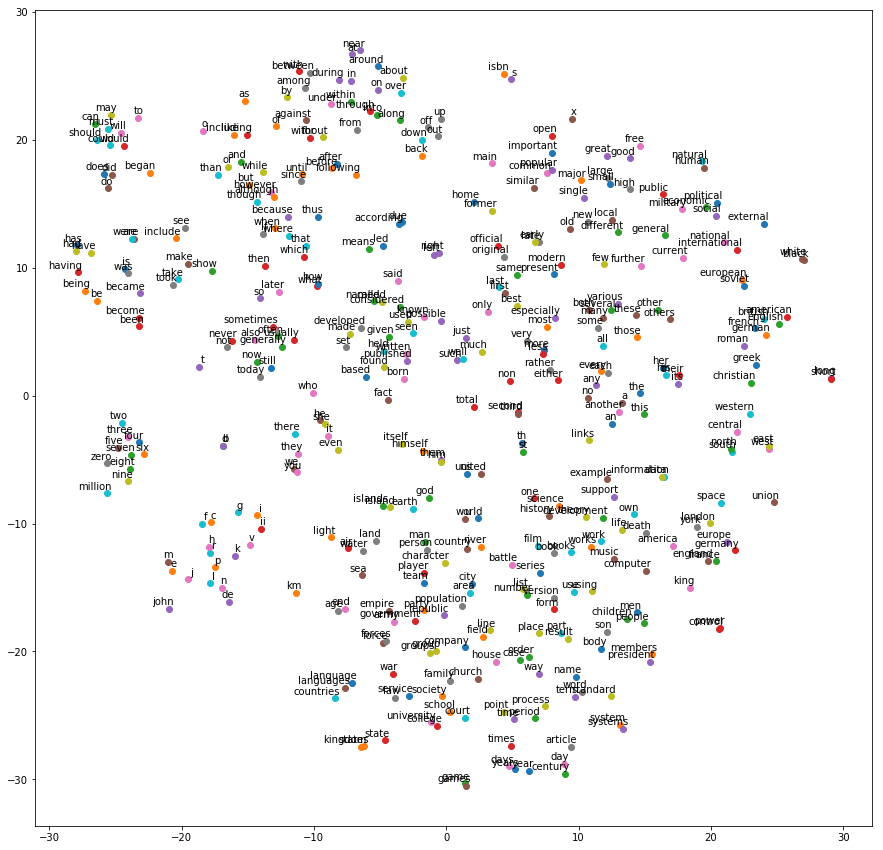

In [13]:
with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, bag_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in range(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8  # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k + 1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalized_embeddings.eval()
num_points = 400

# 计算tsne，可视化词向量在二维空间上的分布
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points + 1, :])
 
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15, 15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i, :]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()
 
 
words = [reverse_dictionary[i] for i in range(1, num_points + 1)]
plot(two_d_embeddings, words)